In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
load_dataset = False
load_model = False

# Dataset preparing

In [11]:
from src.lib.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd
import torch

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = True
load_dataset = True

In [13]:
true_dist_size = 1000
training_dataset_size = int(0.8 * true_dist_size)
alpha = 1
dataset = FactDatasetGenerator(number_person=100,  distribution="zipf", dataset_folder='../src/data/', food_list_name="food_list_small.txt",true_dist_size=true_dist_size, experiment_path="../src/experiment/small_dataset/data/")

In [15]:
if load_dataset:
    dataset.load_dataset()
    true_dist = dataset.true_dist 
    training_data = dataset.training_data
else:
    # Generate all possible facts
    temp = dataset.generate_all_possibilities()
    # Sample true dist (zipf)
    true_dist = dataset.generate_true_dist(alpha=alpha)
    # Sample training data uniformly, %80 of true dist
   
    training_data = dataset.sample_training_data(training_dataset_size,true_dist.tolist())
    print(dataset.vocab_size)
    print(len(temp))

In [16]:
true_dist_df = pd.DataFrame(true_dist,columns=["facts"])

In [17]:
true_dist_df

,facts
0,"Shaun,club sandwich"
1,"Winfield,samosa"
2,"Mel,edamame"
3,"Consolata,beet salad"
4,"Olga,gnocchi"
...,...
995,"Morgana,cheese plate"
996,"El,poutine"
997,"Flore,pad thai"
998,"Flore,pad thai"


In [18]:
true_duplicates_count = true_dist_df.groupby(list(true_dist_df.columns)).size().reset_index(name='count_true')


In [19]:
true_duplicates_count

,facts,count_true
0,"Albertine,bruschetta",1
1,"Albertine,french fries",2
2,"Archibald,caprese salad",1
3,"Archibald,omelette",3
4,"Archibald,pho",1
...,...,...
524,"Zeb,caesar salad",1
525,"Zeb,carrot cake",1
526,"Zeb,creme brulee",1
527,"Zeb,ravioli",1


In [20]:
training_dist_df = pd.DataFrame(training_data,columns=["facts"])
training_duplicates_count = training_dist_df.groupby(list(training_dist_df.columns)).size().reset_index(name='count_train')

In [21]:
training_duplicates_count

,facts,count_train
0,"Albertine,french fries",1
1,"Albertine,ice cream",1
2,"Albertine,spaghetti carbonara",1
3,"Archibald,omelette",2
4,"Archibald,pizza",1
...,...,...
418,"Winfield,seaweed salad",1
419,"Winfield,tiramisu",1
420,"Xenos,baklava",1
421,"Xenos,french toast",3


In [22]:
import torch
## get the training  datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.tokenized_training_data]


In [23]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [24]:
## import mingpt
sys.path.append('minGPT/')
from src.minGPT.mingpt.model import GPT
from src.minGPT.mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocab_size
model_config.model_type = None
model_config.block_size = 3

# model_config.model_type = 'gpt-nano'
# model_config.vocab_size = dataset.vocab_size
# model_config.block_size = 2

model = GPT(model_config).to(device)

number of parameters: 37.93M


In [25]:
# create a Trainer object
from src.minGPT.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cuda


# Training the model

In [26]:
best_iter = 100000000000000
best_epoch = 0
def batch_end_callback(trainer):
    global best_iter
    global best_epoch
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 100:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        if trainer.loss.item() < best_iter:
            best_iter = trainer.loss.item()
            best_epoch = trainer.iter_num
            torch.save(model.state_dict(), dataset.experiment_path[:-5] + "model.pt")
trainer.set_callback('on_batch_end', batch_end_callback)

if load_model:
    model.load_state_dict(torch.load(dataset.experiment_path[:-5]+ "model.pt"))
else:
    trainer.run()
    print(f"Best loss is: {best_iter} on epoch: {best_epoch}")

In [27]:
# now let's perform some evaluation
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(202, 512)
    (wpe): Embedding(3, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_fe

# Generate unconditioned facts

In [28]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [29]:
n_sequences = 1000
from collections import defaultdict
collected_generations = []

for _ in range(n_sequences):
    x = torch.Tensor([0]).unsqueeze(0).long().to(device)
    y_gen = model.generate(x, 2, do_sample=True)
    name = food_item = dataset.decode([y_gen[0][1]])[0]
    food_item = dataset.decode([y_gen[0][2]])[0]
    collected_generations.append(f"{name},{food_item}")

In [30]:
collected_generations_df = pd.DataFrame(collected_generations, columns=["facts"])

In [31]:
collected_generations_counts = collected_generations_df.groupby(list(collected_generations_df.columns)).size().reset_index(name='count_generated')


In [32]:
collected_generations_counts

,facts,count_generated
0,"Albertine,french fries",2
1,"Albertine,spaghetti carbonara",2
2,"Archibald,omelette",2
3,"Archibald,pizza",1
4,"Arlen,chocolate cake",2
...,...,...
336,"gnocchi ,beignets",1
337,"gnocchi ,prime rib",1
338,"miso soup ,escargots",1
339,"pad thai ,spring rolls",1


In [33]:
# Merge true dist and training dist dataframes, outer is used to include data that is not in training data as well
merged_df = pd.merge(true_duplicates_count, training_duplicates_count, on='facts', how='outer')

In [34]:
# Add generated_df to true and training dfs 
# outer can be used to include all facts in true dist
# inner can be used to only show the comparison of generated facts
comparison_df = pd.merge(merged_df, collected_generations_counts, on='facts', how='outer')

In [35]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Albertine,bruschetta",1.0,NaN,NaN
1,"Albertine,french fries",2.0,1.0,2.0
2,"Albertine,ice cream",NaN,1.0,NaN
3,"Albertine,spaghetti carbonara",NaN,1.0,2.0
4,"Archibald,caprese salad",1.0,NaN,NaN
...,...,...,...,...
876,"gnocchi ,beignets",NaN,NaN,1.0
877,"gnocchi ,prime rib",NaN,NaN,1.0
878,"miso soup ,escargots",NaN,NaN,1.0
879,"pad thai ,spring rolls",NaN,NaN,1.0


In [36]:
# Fill in 0 for facts that not appear
comparison_df = comparison_df.fillna(0)

In [37]:
# Normalize the counts by length
comparison_df["count_generated"] = comparison_df['count_generated']/len(collected_generations)
comparison_df["count_train"] = comparison_df['count_train']/len(training_data)
comparison_df["count_true"] = comparison_df['count_true']/len(true_dist)


In [38]:
comparison_df = comparison_df.sort_values(by=['count_generated'], ascending=False)

In [39]:
comparison_df

,facts,count_true,count_train,count_generated
318,"Flore,pad thai",0.110,0.11250,0.090
566,"Mirilla,donuts",0.052,0.06375,0.051
740,"Shaun,club sandwich",0.035,0.03875,0.046
209,"Dyana,spring rolls",0.018,0.02000,0.033
405,"Jeffie,macarons",0.005,0.01750,0.021
...,...,...,...,...
353,"Isadora,falafel",0.001,0.00000,0.000
355,"Isadora,frozen yogurt",0.000,0.00125,0.000
356,"Isadora,greek salad",0.001,0.00000,0.000
358,"Isadora,hamburger",0.001,0.00000,0.000


In [40]:
comparison_df.sum()

facts              Flore,pad thai Mirilla,donuts Shaun,club sandw...
count_true                                                       1.0
count_train                                                      1.0
count_generated                                                  1.0
dtype: object

<Axes: >

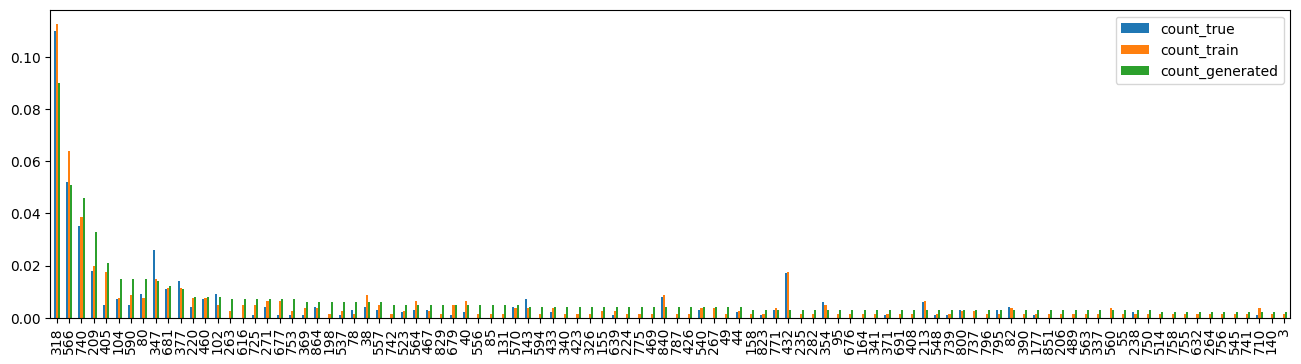

In [41]:
import matplotlib.pyplot as plt
import numpy as np
# Only the top 100 facts graphed for visibility 
comparison_df[:100].plot.bar(figsize=(16, 4))

## Hallucination rates

In [42]:
# True hallucination rate (generations not in true dist)
true_hallucinations = pd.merge(collected_generations_counts, true_duplicates_count, on='facts', how='left')


In [43]:
true_hallucinations

,facts,count_generated,count_true
0,"Albertine,french fries",2,2.0
1,"Albertine,spaghetti carbonara",2,NaN
2,"Archibald,omelette",2,3.0
3,"Archibald,pizza",1,3.0
4,"Arlen,chocolate cake",2,2.0
...,...,...,...
336,"gnocchi ,beignets",1,NaN
337,"gnocchi ,prime rib",1,NaN
338,"miso soup ,escargots",1,NaN
339,"pad thai ,spring rolls",1,NaN


In [44]:
true_hallucinations = true_hallucinations.fillna(0)
try:
    number_of_true_hallucinations =true_hallucinations["count_true"].value_counts()[0]
    true_hallucinations_rate = number_of_true_hallucinations / len(collected_generations)
except:
    number_of_true_hallucinations = 0
    true_hallucinations_rate = 0
print(f"Rate of true hallucinations: {true_hallucinations_rate} ")

Rate of true hallucinations: 0.24 


In [45]:
# Naive hallucination rate (every generation not in training data)
naive_hallucinations = pd.merge(collected_generations_counts, training_duplicates_count, on='facts', how='left')

In [46]:
naive_hallucinations

,facts,count_generated,count_train
0,"Albertine,french fries",2,1.0
1,"Albertine,spaghetti carbonara",2,1.0
2,"Archibald,omelette",2,2.0
3,"Archibald,pizza",1,1.0
4,"Arlen,chocolate cake",2,3.0
...,...,...,...
336,"gnocchi ,beignets",1,NaN
337,"gnocchi ,prime rib",1,NaN
338,"miso soup ,escargots",1,NaN
339,"pad thai ,spring rolls",1,NaN


In [47]:
naive_hallucinations = naive_hallucinations.fillna(0)
try:
    number_of_naive_hallucinations = naive_hallucinations["count_train"].value_counts()[0]
    naive_hallucinations_rate = number_of_naive_hallucinations / len(collected_generations)
except:
    number_of_naive_hallucinations = 0
    naive_hallucinations_rate = 0

print(f"Rate of naive hallucinations: {naive_hallucinations_rate} ")

Rate of naive hallucinations: 0.055 


In [48]:
naive_hallucinations_df = naive_hallucinations[naive_hallucinations["count_train"] == 0]

In [49]:
naive_hallucinations_df

,facts,count_generated,count_train
13,"Bendite,pork chop",1,0.0
16,"Benita,paella",1,0.0
22,"Candice,Olga",1,0.0
23,"Candice,ceviche",1,0.0
36,"Charis,seaweed salad",1,0.0
40,"Consolata,omelette",1,0.0
53,"Deidre,Molli",1,0.0
58,"Deidre,lasagna",1,0.0
60,"Deidre,prime rib",1,0.0
68,"Dorelia,spaghetti bolognese",1,0.0


In [50]:
hallucinations_list = naive_hallucinations_df["facts"].tolist()

### Monofact rate

In [51]:
try:
    MF = training_duplicates_count["count_train"].value_counts()[1] / len(training_data)
    mf_df = training_duplicates_count[training_duplicates_count["count_train"] < 4]
    monofact_list = mf_df["facts"].tolist()
except:
    MF = 0
MF

0.43875

### Miscalibration

In [52]:
from src.lib.calibration import miscalibration

In [53]:
comparison_sorted_by_generated = comparison_df.sort_values(by='count_generated', ascending=False)

In [54]:
miscalibration_rate = miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_true'])
miscalibration_rate

Adaptive binning with 11 bins
bin with g_proba / p_proba 0.09 0.11
bin with g_proba / p_proba 0.051 0.052
bin with g_proba / p_proba 0.079 0.053000000000000005
bin with g_proba / p_proba 0.08 0.052000000000000005
bin with g_proba / p_proba 0.08900000000000002 0.052000000000000005
bin with g_proba / p_proba 0.08700000000000001 0.026000000000000002
bin with g_proba / p_proba 0.08800000000000005 0.028000000000000004
bin with g_proba / p_proba 0.09000000000000004 0.043000000000000003
bin with g_proba / p_proba 0.08900000000000007 0.031
bin with g_proba / p_proba 0.09000000000000007 0.015000000000000001
bin with g_proba / p_proba 0.09000000000000007 0.023000000000000003
bin with g_proba / p_proba 0.07700000000000005 0.5150000000000001


0.47172933549432744

In [55]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_train'])

Adaptive binning with 11 bins
bin with g_proba / p_proba 0.09 0.1125
bin with g_proba / p_proba 0.051 0.06375
bin with g_proba / p_proba 0.079 0.05875
bin with g_proba / p_proba 0.08 0.05625
bin with g_proba / p_proba 0.08900000000000002 0.06999999999999999
bin with g_proba / p_proba 0.08700000000000001 0.053750000000000006
bin with g_proba / p_proba 0.08800000000000005 0.05125000000000002
bin with g_proba / p_proba 0.09000000000000004 0.0675
bin with g_proba / p_proba 0.08900000000000007 0.07250000000000001
bin with g_proba / p_proba 0.09000000000000007 0.06750000000000002
bin with g_proba / p_proba 0.09000000000000007 0.07750000000000001
bin with g_proba / p_proba 0.07700000000000005 0.24875000000000003


0.25295664505672605

### Check if it holds

In [56]:
unique_names = len(set([t[1] for t in train_dataset]))
unique_foods = len(set([t[2] for t in train_dataset]))
# Possible generations
POSS_GENERATIONS = unique_names * unique_foods

# Facts to all possibilities - facts, approximated
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS = 300 * len(training_duplicates_count) / (POSS_GENERATIONS - len(training_duplicates_count))

In [57]:
HALLUCINATION_RATE = true_hallucinations_rate

#MF = 0.43875

MISCALIBRATION = miscalibration_rate

In [58]:
MF

0.43875

In [59]:
MISCALIBRATION

0.47172933549432744

In [60]:
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

0.1984123881878179

In [61]:
MF - MISCALIBRATION

-0.032979335494327466

In [62]:
7 / np.sqrt(len(training_data))

0.24748737341529162

In [63]:
estimated_hallucination_rate = MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS
estimated_hallucination_rate

-0.47887909709743703

In [64]:
HALLUCINATION_RATE

0.24

In [65]:
HALLUCINATION_RATE > MF - MISCALIBRATION

True

In [66]:
HALLUCINATION_RATE > MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

True

In [67]:
import json
def save_results():
    experiment = {}
    experiment['number of person'] = dataset.number_person
    experiment['food_list'] = dataset.food_list_name
    experiment['true_dist_size'] = dataset.true_dist_size
    experiment['training_set_size'] = len(training_data)
    experiment['zipf_alpha'] = alpha
    experiment['monofact_rate'] = MF
    experiment['miscalibration_rate'] = MISCALIBRATION
    experiment['facts_to_possible_hallucinations_ratio'] = APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS
    experiment['estimated_hallucinations_rate'] = estimated_hallucination_rate
    experiment['naive_hallucinations_rate'] = naive_hallucinations_rate
    experiment['true_hallucinations_rate'] = true_hallucinations_rate
    
    json_str = json.dumps(experiment)
    with open('experiment/experiments.json', 'a') as file:
        file.write(json_str + '\n')
        
    

In [68]:
#save_results()

In [69]:
x = torch.Tensor([0]).unsqueeze(0).long().to(device)
output, loss, hidden_states = model(x,output_hidden_states=True)
print(hidden_states)

[tensor([[[ 0.0158, -0.0005, -0.0089, -0.0215,  0.0131,  0.0137,  0.0015,
           0.0572,  0.0434,  0.0130,  0.0131,  0.0453, -0.0681, -0.0147,
           0.0474,  0.0320,  0.0514,  0.0647, -0.0002, -0.0223, -0.0735,
          -0.0297,  0.0435,  0.0372,  0.0025,  0.0365, -0.0421,  0.0155,
          -0.0159, -0.0409, -0.0588, -0.0276, -0.0130, -0.0136, -0.0307,
           0.0266,  0.0063, -0.0225,  0.0087,  0.0334,  0.0129, -0.0173,
          -0.0240, -0.0418,  0.0547,  0.0417, -0.0142, -0.0543, -0.0115,
          -0.0298,  0.0161,  0.0472, -0.0608, -0.0402,  0.0054, -0.0135,
           0.0170,  0.0293,  0.0206, -0.0349, -0.0281, -0.0209, -0.0511,
          -0.0123,  0.0383, -0.0287,  0.0106,  0.0138,  0.0072,  0.0102,
          -0.0166,  0.0504, -0.0086,  0.0744,  0.0080, -0.0232,  0.0089,
          -0.0010,  0.0118,  0.0112,  0.0078, -0.0674, -0.0120, -0.0261,
           0.0329,  0.0294, -0.0429, -0.0199, -0.0052, -0.0018, -0.0275,
           0.0511,  0.0258,  0.0050,  0.0065,  0.0

In [70]:
last_hidden_state = hidden_states[-1]


In [71]:
last_hidden_state.flatten().shape

torch.Size([512])

In [78]:
tokenized_hallucinations = dataset.tokenize_data(hallucinations_list)
tokenized_monofacts = dataset.tokenize_data(monofact_list)
tokenized_generated_facts = dataset.tokenize_data(collected_generations)

In [73]:
final_hidden_states = []

monofact_embeddings = []
normal_fact_embeddings = []
for fact in train_dataset:
    output, loss, hidden_states = model(fact.unsqueeze(0).long().to(device),output_hidden_states=True)
    fact = fact.cpu().tolist()
    if fact in tokenized_monofacts:
        monofact_embeddings.append((fact, hidden_states[-1].flatten()))
    else:
        normal_fact_embeddings.append((fact,hidden_states[-1].flatten()))
    final_hidden_states.append((fact, hidden_states[-1].flatten()))
    

In [74]:
hallucination_embeddings = []
for fact in tokenized_hallucinations:
    output, loss, hidden_states = model(torch.tensor(fact).unsqueeze(0).long().to(device),output_hidden_states=True)
    
    hallucination_embeddings.append((fact, hidden_states[-1].flatten()))
    

In [80]:
generated_fact_embeddings = []
for fact in tokenized_generated_facts:
    output, loss, hidden_states = model(torch.tensor(fact).unsqueeze(0).long().to(device),output_hidden_states=True)
    
    generated_fact_embeddings.append((fact, hidden_states[-1].flatten()))

In [75]:
print(len(final_hidden_states))
print(len(hallucination_embeddings))
print(len(monofact_embeddings))
print(len(normal_fact_embeddings))

800
55
460
340


In [76]:

def mahalanobis_distance(vector1, vector2, covariance_matrix):
    diff = vector1.to(device) - vector2.to(device)
    inv_cov = torch.inverse(covariance_matrix)
    return torch.sqrt(torch.matmul(torch.matmul(diff, inv_cov), diff))




In [77]:
monofact_similarity = np.ndarray(shape=(len(hallucination_embeddings),len(monofact_embeddings)))
normal_fact_similarity = np.ndarray(shape=(len(hallucination_embeddings),len(normal_fact_embeddings)))
for i, hallucination in enumerate(hallucination_embeddings):
    hallucinated_fact, hallucination_embedding = hallucination
    for j, monofact in enumerate(monofact_embeddings):
        monofact_fact, monofact_embedding = monofact
        monofact_similarity[i][j] = torch.norm(hallucination_embedding - monofact_embedding, p=1).cpu().detach().numpy()
        #monofact_similarity[i][j] = mahalanobis_distance(hallucination_embedding, monofact_embedding, torch.eye(512*3).to(device)).cpu().detach().numpy()
    for h, normal_fact in enumerate(normal_fact_embeddings):
        fact, fact_embedding = normal_fact
        normal_fact_similarity[i][h] = torch.norm(hallucination_embedding - fact_embedding, p=1).cpu().detach().numpy()
        #normal_fact_similarity[i][h] = mahalanobis_distance(hallucination_embedding, fact_embedding, torch.eye(512*3).to(device)).cpu().detach().numpy()

KeyboardInterrupt: 

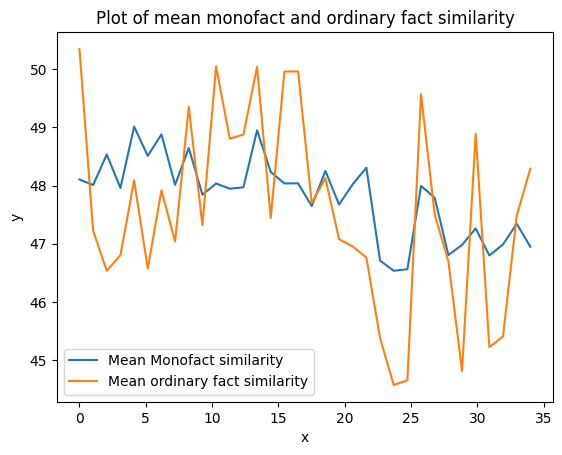

In [137]:
temp1 = monofact_similarity.mean(axis=1)
temp2 = normal_fact_similarity.mean(axis=1)
# Generate some sample data
x = np.linspace(0, len(hallucination_embeddings), len(hallucination_embeddings))  # 34 data points from 0 to 10
y1 = temp1
y2 = temp2

# Plotting both arrays on the same axis
plt.plot(x, y1, label='Mean Monofact similarity')
plt.plot(x, y2, label='Mean ordinary fact similarity')

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of mean monofact and ordinary fact similarity')
plt.legend()

# Display the plot
plt.show()


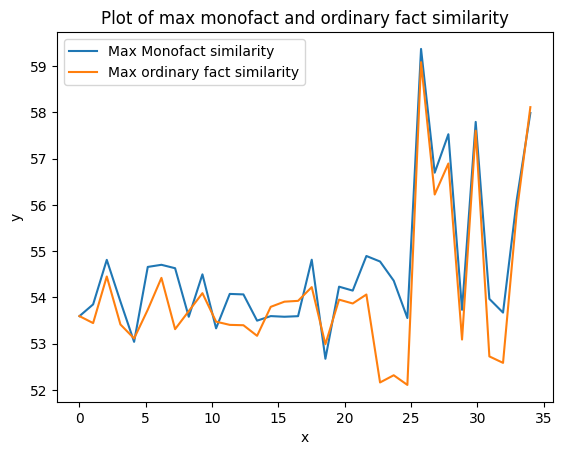

In [138]:
temp1 = monofact_similarity.max(axis=1)
temp2 = normal_fact_similarity.max(axis=1)
# Generate some sample data
x = np.linspace(0, len(hallucination_embeddings), len(hallucination_embeddings))  # 34 data points from 0 to 10
y1 = temp1
y2 = temp2

# Plotting both arrays on the same axis
plt.plot(x, y1, label='Max Monofact similarity')
plt.plot(x, y2, label='Max ordinary fact similarity')

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of max monofact and ordinary fact similarity')
plt.legend()

# Display the plot
plt.show()


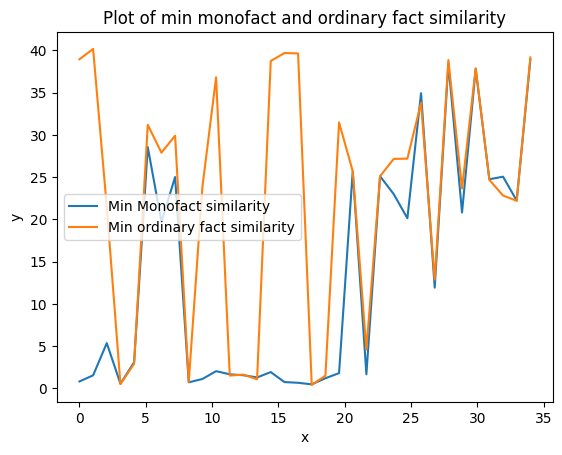

In [139]:
temp1 = monofact_similarity.min(axis=1)
temp2 = normal_fact_similarity.min(axis=1)
# Generate some sample data
x = np.linspace(0, len(hallucination_embeddings), len(hallucination_embeddings))  # 34 data points from 0 to 10
y1 = temp1
y2 = temp2

# Plotting both arrays on the same axis
plt.plot(x, y1, label='Min Monofact similarity')
plt.plot(x, y2, label='Min ordinary fact similarity')

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of min monofact and ordinary fact similarity')
plt.legend()

# Display the plot
plt.show()


In [122]:
for hallucinated_fact, _ in hallucination_embeddings[20:25]:
    print(dataset.decode(hallucinated_fact))

['<s>', 'Tana', 'baklava ']
['<s>', 'Violetta', 'Arlen']
['<s>', 'chicken curry ', 'dumplings ']
['<s>', 'chicken wings ', 'cannoli ']
['<s>', 'fish and chips ', 'poutine ']


In [123]:
i = 0
for hallucinated_fact, _ in hallucination_embeddings:
    print(i)
    print(dataset.decode(hallucinated_fact))
    i += 1

0
['<s>', 'Astrix', 'pork chop ']
1
['<s>', 'Benita', 'pad thai ']
2
['<s>', 'Deane', 'tuna tartare ']
3
['<s>', 'Deidre', 'macaroni and cheese ']
4
['<s>', 'Edith', 'Augustine']
5
['<s>', 'Edith', 'Valerie']
6
['<s>', 'Ermentrude', 'ramen ']
7
['<s>', 'Felicio', 'Violetta']
8
['<s>', 'Jacinthe', 'paella ']
9
['<s>', 'Jammal', 'Kathlin']
10
['<s>', 'Karil', 'fish and chips ']
11
['<s>', 'Katey', 'chicken quesadilla ']
12
['<s>', 'Katey', 'waffles']
13
['<s>', 'Koressa', 'oysters ']
14
['<s>', 'Morry', 'pad thai ']
15
['<s>', 'Neddy', 'croque madame ']
16
['<s>', 'Neddy', 'guacamole ']
17
['<s>', 'Ranee', 'pork chop ']
18
['<s>', 'Rossy', 'caesar salad ']
19
['<s>', 'Simon', 'Marlin']
20
['<s>', 'Tana', 'baklava ']
21
['<s>', 'Violetta', 'Arlen']
22
['<s>', 'chicken curry ', 'dumplings ']
23
['<s>', 'chicken wings ', 'cannoli ']
24
['<s>', 'fish and chips ', 'poutine ']
25
['<s>', 'french fries ', 'escargots ']
26
['<s>', 'french onion soup ', 'chicken quesadilla ']
27
['<s>', 'fried ca

### Saving Embeddings

In [82]:
import json
with open("../src/experiment/monofact_embeddings.json","w") as f:
    for line in monofact_embeddings:
        f.write(json.dumps((line[0],line[1].tolist())) + "\n")
with open("../src/experiment/hallucination_embeddings.json","w") as f:
    for line in hallucination_embeddings:
        f.write(json.dumps((line[0],line[1].tolist())) + "\n")
with open("../src/experiment/normal_fact_embeddings.json","w") as f:
    for line in normal_fact_embeddings:
        f.write(json.dumps((line[0],line[1].tolist())) + "\n")
with open("../src/experiment/generated_fact_embeddings.json","w") as f:
    for line in generated_fact_embeddings:
        f.write(json.dumps((line[0],line[1].tolist())) + "\n")

### Loading embeddings

In [74]:
loaded_monofact_embeddings = []
loaded_normal_fact_embeddings = []
loaded_hallucination_embeddings = []


with open("../src/experiment/monofact_embeddings.json","r") as f:
    for line in f:
        loaded_monofact_embeddings.append(json.loads(line))
with open("../src/experiment/hallucination_embeddings.json","r") as f:
    for line in f:
        loaded_hallucination_embeddings.append(json.loads(line))
with open("../src/experiment/normal_fact_embeddings.json","r") as f:
    for line in f:
        loaded_normal_fact_embeddings.append(json.loads(line))
        


In [78]:
monofact_embeddings = []
hallucination_embeddings = []
normal_fact_embeddings = []
for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
    monofact_embeddings.append((loaded_monofact, torch.tensor(loaded_monofact_embedding)))
for loaded_hallucination, loaded_hallucination_embedding in loaded_hallucination_embeddings:
    hallucination_embeddings.append((loaded_hallucination, torch.tensor(loaded_hallucination_embedding)))
for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
    normal_fact_embeddings.append((loaded_normal_fact, torch.tensor(loaded_normal_fact_embedding)))

[([0, 7, 180],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.0666,  3.3867,  0.0594])),
 ([0, 82, 85],
  tensor([ 0.5362, -0.0391,  4.4602,  ..., -0.5822,  0.8617,  0.7569])),
 ([0, 54, 12],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  1.4260,  1.0563, -1.2991])),
 ([0, 66, 67],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.3304, -1.2571, -1.7041])),
 ([0, 161, 67],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.3070, -0.5973, -0.1049])),
 ([0, 161, 30],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.2279, -0.5496, -0.0293])),
 ([0, 82, 61],
  tensor([ 0.5362, -0.0391,  4.4602,  ..., -0.5703, -0.5766,  0.7296])),
 ([0, 114, 122],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.1944,  3.2436,  0.0386])),
 ([0, 17, 2],
  tensor([ 0.5362, -0.0391,  4.4602,  ..., -1.4377, -0.1571,  1.6726])),
 ([0, 5, 12],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.6330,  1.0203, -1.6901])),
 ([0, 181, 160],
  tensor([ 0.5362, -0.0391,  4.4602,  ..., -0.4523,  0.3680, -0.3557])),
 ([0, 75, 76],
  tensor([ 0.

In [80]:
torch.cuda.empty_cache()